In [66]:
from tqdm import tqdm
import numpy as np
import random
import os
from os.path import join
import math
import shutil
from shutil import copy
import torch
import torch.nn as nn
import torch.optim as optim
from torch_lr_finder import LRFinder
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision.transforms import transforms
from torchvision.datasets import ImageFolder
import torchvision.models as models
from PIL import Image
import matplotlib.pyplot as plt
import albumentations.augmentations as A
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True
np.random.seed(0)
random.seed(0)

In [67]:
dirs = ['test', 'train']

In [68]:
buff = os.listdir(dirs[1])

def getFilenames(path):
    out = []
    for dirpath, dirnames, filenames in os.walk(dirs[1]):
        dirpath = dirpath.replace('\\', '/')
        for file in filenames:
            if file.find('.jpg') > 0:
                out.append(f'{dirpath}/{file}')
    return out

if 'train' and 'val' in buff:
    shutil.rmtree(f'{dirs[1]}/train')
    shutil.rmtree(f'{dirs[1]}/val')
    os.makedirs(f'{dirs[1]}/train/cleaned')
    os.makedirs(f'{dirs[1]}/train/dirty')
    os.makedirs(f'{dirs[1]}/val/cleaned')
    os.makedirs(f'{dirs[1]}/val/dirty')
else:
    print(buff)
    os.makedirs(f'{dirs[1]}/train/cleaned')
    os.makedirs(f'{dirs[1]}/train/dirty')
    os.makedirs(f'{dirs[1]}/val/cleaned')
    os.makedirs(f'{dirs[1]}/val/dirty')

filenames = getFilenames(dirs[1])
for i, file in enumerate(filenames):
    if i % 5 == 0:
        name = 'cleaned' if 'cleaned' in file else 'dirty'
        copy(file, f'{dirs[1]}/val/{name}/{i}{name}.jpg')
    else:
        copy(file, f'{dirs[1]}/train/{name}/{i}{name}.jpg')

In [197]:
crop = 224
size = 256
transform = transforms.Compose([
    transforms.Resize([size, size]),
    transforms.CenterCrop([crop, crop]),
    transforms.RandomRotation(30),
    transforms.RandomAdjustSharpness(sharpness_factor=2, p=1),
    transforms.RandomInvert(p=1),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.5152, 0.4801, 0.4646], [0.2315, 0.2449, 0.2590])
])
transformval = transforms.Compose([
    transforms.Resize([size, size]),
    transforms.CenterCrop([crop, crop]),
    transforms.RandomAdjustSharpness(sharpness_factor=2, p=1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

trainPath = 'train/train'
valPath = 'train/val'

trainData = ImageFolder('train/train', transform)
valData = ImageFolder('train/val', transformval)

batch_size = 8
num_workers = 0
train_loader = DataLoader(trainData, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(valData, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [ ]:
def normCalc(dataloader):
    channels, chsq, batch = 0, 0, 0
    for x, _ in dataloader:
        channels += x.mean([0,2,3])
        chsq += (x**2).mean([0,2,3])
        batch += 1
        
    mean = channels / batch
    std = (chsq / batch - mean ** 2) ** 0.5
    return mean, std

normCalc(train_loader)

In [198]:
def imshow(model, loader):
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    model.eval()
    x, _ = next(iter(loader))
    pred = model(x)

    for i in range(len(x)):
        title = pred.argmax(dim=1).numpy()
        plt.imshow(x[i].permute(1,2,0).numpy()* std + mean)
        plt.title('dirty' if title[i] == 1 else 'cleaned')
        plt.show()
    
len(train_loader)

4

In [201]:
model = models.resnet18(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Linear(model.fc.in_features, 2)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), amsgrad=True, lr=0.002)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5)

  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 2.01E-03


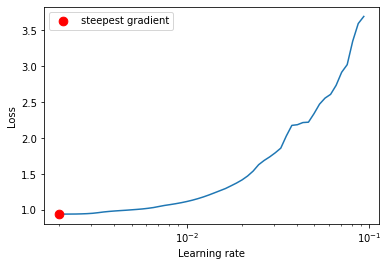

In [200]:
lr_finder = LRFinder(model, optimizer, loss, 'cpu')
lr_finder.range_test(train_loader, val_loader=val_loader, end_lr=1.0, num_iter=100)
lr_finder.plot()
lr_finder.reset()

In [202]:
train_loss = []
train_acc = []
val_acc = []
val_loss = []
def trainModel(model, loss, optimizer, epochs, scheduler=None):
    for epoch in range(epochs):
        for phase in ["train", "val"]:
            if phase == "train":
                model.train()
                loader = train_loader
            else:
                model.eval()
                loader = val_loader
                
            for inputs, labels in tqdm(loader):
                inputs.to(device)
                labels.to(device)
                
                with torch.set_grad_enabled(phase == 'train'):
                    pred = model(inputs)
                    loss_value = loss(pred, labels)
                    acc = (pred.argmax(dim=1) == labels.data).float().mean()
                    
                    if phase == 'train':
                        optimizer.zero_grad()
                        loss_value.backward()
                        optimizer.step()
                        train_loss.append(loss_value.data)
                        train_acc.append(acc)
                    else:
                        val_acc.append(acc)
                        val_loss.append(loss_value.data)
                    
        scheduler.step(loss_value)
        print(f"{epoch} acc {acc} loss {loss_value}")

In [203]:
trainModel(model, loss, optimizer, 100, scheduler)

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.14it/s]


0 acc 0.375 loss 0.9098429679870605


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.22it/s]


1 acc 0.375 loss 1.0161985158920288


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.25it/s]


2 acc 0.5 loss 1.2093511819839478


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.30it/s]


3 acc 0.375 loss 1.0620754957199097


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.51it/s]


4 acc 0.375 loss 1.146447777748108


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.04s/it]


5 acc 0.375 loss 1.108850121498108


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.08it/s]


6 acc 0.375 loss 1.1926583051681519


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.89it/s]


7 acc 0.25 loss 1.2259937524795532


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.34it/s]


8 acc 0.375 loss 1.2120633125305176


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.86it/s]


9 acc 0.375 loss 1.1897310018539429


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.78it/s]


10 acc 0.375 loss 1.1830419301986694


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.41it/s]


11 acc 0.375 loss 1.1626044511795044


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.11it/s]


12 acc 0.375 loss 1.1574366092681885


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.99it/s]


13 acc 0.375 loss 1.1545416116714478


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.04it/s]


14 acc 0.375 loss 1.1464794874191284


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.04it/s]


15 acc 0.375 loss 1.1410223245620728


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.98it/s]


16 acc 0.375 loss 1.1481549739837646


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.43it/s]


17 acc 0.375 loss 1.1718724966049194


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.53it/s]


18 acc 0.375 loss 1.1651442050933838


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.45it/s]


19 acc 0.375 loss 1.1758992671966553


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.48it/s]


20 acc 0.375 loss 1.2002978324890137


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.50it/s]


21 acc 0.375 loss 1.1834291219711304


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.38it/s]


22 acc 0.375 loss 1.1888689994812012


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.35it/s]


23 acc 0.375 loss 1.1743580102920532


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.39it/s]


24 acc 0.375 loss 1.1836907863616943


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.49it/s]


25 acc 0.375 loss 1.185282826423645


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.50it/s]


26 acc 0.375 loss 1.1854889392852783


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.35it/s]


27 acc 0.375 loss 1.1670575141906738


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.51it/s]


28 acc 0.375 loss 1.1477910280227661


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.37it/s]


29 acc 0.375 loss 1.1693038940429688


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.45it/s]


30 acc 0.375 loss 1.180040717124939


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.44it/s]


31 acc 0.375 loss 1.1483232975006104


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.44it/s]


32 acc 0.375 loss 1.1519674062728882


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.54it/s]


33 acc 0.375 loss 1.1650484800338745


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.39it/s]


34 acc 0.375 loss 1.1828691959381104


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.48it/s]


35 acc 0.375 loss 1.184302806854248


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.46it/s]


36 acc 0.375 loss 1.1882262229919434


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.35it/s]


37 acc 0.375 loss 1.1717569828033447


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.26it/s]


38 acc 0.375 loss 1.1672073602676392


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.31it/s]


39 acc 0.375 loss 1.1527538299560547


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.18it/s]


40 acc 0.375 loss 1.1459075212478638


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.26it/s]


41 acc 0.375 loss 1.1729278564453125


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.51it/s]


42 acc 0.375 loss 1.1641387939453125


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.48it/s]


43 acc 0.375 loss 1.1794670820236206


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.41it/s]


44 acc 0.375 loss 1.182966709136963


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.99it/s]


45 acc 0.375 loss 1.179011344909668


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.31it/s]


46 acc 0.375 loss 1.1959559917449951


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.47it/s]


47 acc 0.375 loss 1.1815053224563599


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.38it/s]


48 acc 0.375 loss 1.2120734453201294


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.45it/s]


49 acc 0.375 loss 1.200917363166809


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.39it/s]


50 acc 0.375 loss 1.2063863277435303


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.49it/s]


51 acc 0.375 loss 1.2127413749694824


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.38it/s]


52 acc 0.375 loss 1.1976420879364014


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.02it/s]


53 acc 0.375 loss 1.1857117414474487


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.71it/s]


54 acc 0.375 loss 1.1571106910705566


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.73it/s]


55 acc 0.375 loss 1.1700468063354492


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.43it/s]


56 acc 0.375 loss 1.1827179193496704


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.45it/s]


57 acc 0.375 loss 1.1979849338531494


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.04it/s]


58 acc 0.375 loss 1.1807780265808105


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.99it/s]


59 acc 0.375 loss 1.206192135810852


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.63it/s]


60 acc 0.375 loss 1.2023361921310425


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.45it/s]


61 acc 0.375 loss 1.1927202939987183


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.30it/s]


62 acc 0.25 loss 1.188731074333191


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.95it/s]


63 acc 0.25 loss 1.1808338165283203


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.52it/s]


64 acc 0.25 loss 1.1939165592193604


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.32it/s]


65 acc 0.25 loss 1.2212563753128052


 75%|██████████████████████████████████████████████████████████████▎                    | 3/4 [00:02<00:00,  1.36it/s]


KeyboardInterrupt: 

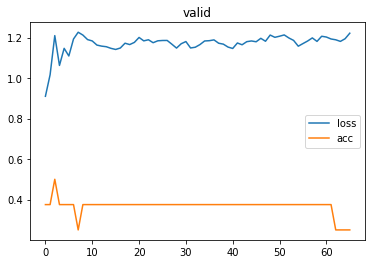

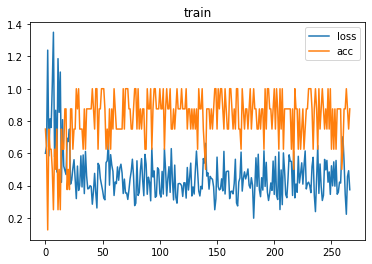

In [204]:
plt.plot(val_loss)
plt.plot(val_acc)
plt.title('valid')
plt.legend(["loss", "acc"])
plt.show()
plt.plot(train_loss)
plt.plot(train_acc)
plt.title("train")
plt.legend(["loss", "acc"])
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


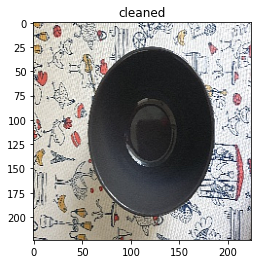

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


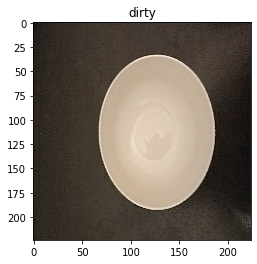

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


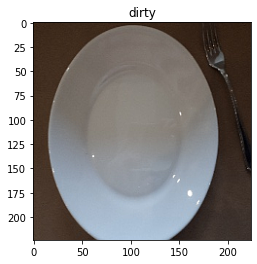

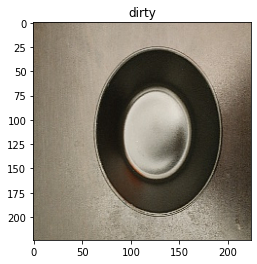

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


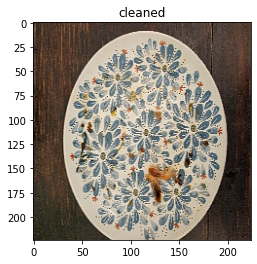

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


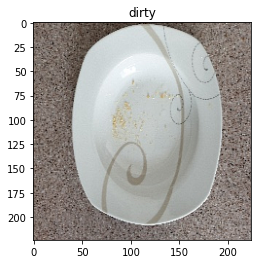

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


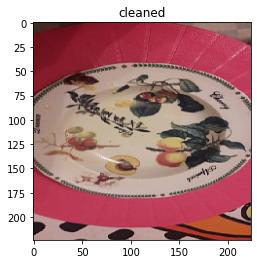

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


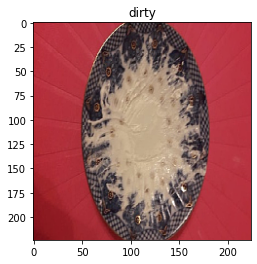

In [208]:
imshow(model, val_loader)